In [2]:
import numpy as np
from scipy import special
import math
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Create array of correct dimensions to store data.
dataWidth = 7 # for simplicity used for vertical bars as well
barWidth = 2
frameNum = dataWidth - barWidth + 1 # until bar reaches the other side
seqNum = 8 # (vertical, horizontal, diagonal 1, diagonal 2 bar) * (direction 1, 2) 
data = np.zeros(shape=(seqNum, frameNum, dataWidth, dataWidth))
flat_data = np.zeros(shape=(seqNum, frameNum, dataWidth**2))

# For diagonal bars: Create larger, still image with diagonal in the center and later take shifting quadratic frames from it
diagonal_full_1 = np.zeros([dataWidth,3*dataWidth])
diagonal_full_2 = np.zeros([dataWidth,3*dataWidth])
for i in range(barWidth):
    diagonal_full_1 += np.roll(np.concatenate((np.zeros([dataWidth,dataWidth]), np.identity(dataWidth), np.zeros([dataWidth,dataWidth])),1), -i)
    diagonal_full_2 += np.roll(np.concatenate((np.zeros([dataWidth,dataWidth]), np.fliplr(np.identity(dataWidth)), np.zeros([dataWidth,dataWidth])),1), -i)
    
# Create frames.
for seqit in range(seqNum):
    for frameit in range(frameNum):
        # Horizontal bars
        if seqit<2:
            for barit in range(barWidth):
                data[seqit, frameit, barit+frameit, :] = 1 # Position of bar is shifted each frameit
            # Flip second sequence: Upward moving bar
            if seqit == 1 :
                data[seqit, frameit] = np.flipud(data[seqit, frameit])
        # Vertical bars
        elif seqit<4:
            for barit in range(barWidth):
                data[seqit, frameit, :, barit+frameit] = 1
            if seqit == 3:
                data[seqit, frameit] = np.fliplr(data[seqit, frameit])
        # Diagonal bars 1
        elif seqit == 4:
            startId = dataWidth-barWidth+int(dataWidth/2)-frameit+1
            data[seqit, frameit] = diagonal_full_1[:,(startId):(startId+dataWidth)]   
        elif seqit == 5: 
                data[seqit, frameit] = data[4, frameNum-1-frameit] # Reverse order of sequence 4
        # Diagonal bars 2
        elif seqit == 6:
            startId = dataWidth-barWidth+int(dataWidth/2)-frameit+1
            data[seqit, frameit] = diagonal_full_2[:,(startId):(startId+dataWidth)]
        elif seqit == 7: 
                data[seqit, frameit] = data[6, frameNum-1-frameit]

        flat_data[seqit, frameit] = data[seqit, frameit].flatten() # Make each frame 1D to use as network input

sign = 1 # depends on convention, but shouldn't change anything

class layer:
    def __init__(self, layer_size, nextlayer_size, i_rate, l_rate, islast):
        self.islast = islast # is last layer
        self.size = layer_size # number of neurons in this layer
        #self.y_activation = np.random.rand(layer_size) - 0.5 # before activation function
        self.y_activation = 0.1*np.random.rand(layer_size)
        self.y_activity = actfun(self.y_activation)
        self.e_activation = None # activation of error neurons 
        self.e_activity = None # after activation function
        self.td_prediction = None # top-down prediction
        self.bu_error = None # accumulated errors ascending to this layer
        self.weights = None # weights toward higher layer
        self.gradients = np.zeros(layer_size) # To store gradient for batchwise training
        if(self.islast == False):
            self.weights = np.random.normal(0,0.5, [layer_size, nextlayer_size])
            #self.weights = np.random.rand(layer_size, nextlayer_size)
            self.weights = self.weights.clip(min=0)
            self.weights *=  1/nextlayer_size #layer_size/nextlayer_size
        self.inference_rate = i_rate # Rate of activity updates (inference rate)
        self.learning_rate = l_rate # Rate of weight updates (learning rate)
        self.alpha_y = 0 #0.0001 # Parameter for activity regularization
        self.alpha_w = 0#0.0001 # Parameter for weight regularization
        #self.bias = np.random.rand(1, output_size) - 0.5 # Todo: Add bias
        
class network:
    def __init__(self):
        self.layers = [] # layers 
        self.num_layers = 0 # Total number of layers
        
    def add(self, layer):
        self.layers.append(layer)
        self.num_layers += 1
    
    def reset_act(self):
        for layer in self.layers:
            layer.y_activation = -2*np.ones(layer.size) #0.1*np.ones(layer.size) 
            layer.y_activity = actfun(layer.y_activation)
    
    def inference_pass(self, input, inference_steps):
        if(np.size(input)!=self.layers[0].size): # Test if number of input neurons matches input dim.
            raise ValueError("Input dimension " + "("+ str(np.size(input)) +") and number of input neurons " + "("+ str(self.layers[0].size) + ") does not match")
        
        # Set activity of lowest layer to input
        self.layers[0].y_activity = input
        
        for k in range(inference_steps):
        # Calculate errors in one pass
            for layer in self.layers:
                if(layer.islast == False): # If not last layer compute error towards higher layer
                    layer.td_prediction = layer.weights.dot(self.layers[self.layers.index(layer)+1].y_activity)
                    layer.e_activation = sign*(layer.y_activity - layer.td_prediction)
                    layer.e_activity = layer.e_activation # Now linear. optional: activation function for error units
                if(self.layers.index(layer)!=0): # If not first layer calculate bu_errors and conduct inference
                    layer.bu_error = self.layers[self.layers.index(layer)-1].weights.T.dot(self.layers[self.layers.index(layer)-1].e_activity)
            
        # Update activities in new pass
            for layer in self.layers: 
                # layers in between influenced from top and bottom
                if(layer.islast == False and self.layers.index(layer) != 0):
                    layer.y_activation += sign*layer.inference_rate*(layer.bu_error - layer.e_activity) - layer.alpha_y
                    layer.y_activity = actfun(layer.y_activation)
                # highest layer has only bottom-up influence
                elif(layer.islast == True): 
                    layer.y_activation += sign*layer.inference_rate*layer.bu_error - layer.alpha_y
                    layer.y_activity = actfun(layer.y_activation)

    
    def learn_pass(self):
        for layer in self.layers:
            if(layer.islast == False):
                layer.weights += layer.learning_rate*sign*np.atleast_2d(layer.e_activity).T.dot(np.atleast_2d(self.layers[self.layers.index(layer)+1].y_activity))
                layer.weights -= layer.alpha_w # This operation regularizes the weights.
                layer.weights = layer.weights.clip(min=0)
            else:
                pass
            
    def forward_pass(self, input_frame):
        # Single pass in which activity propagates in a FF-manner.
        for layer in self.layers:
            if self.layers.index(layer)==0:
                layer.y_activation = input_frame
                layer.y_activity = actfun(layer.y_activation)
            else:
                layer.y_activation = self.layers[self.layers.index(layer)-1].weights.T.dot(self.layers[self.layers.index(layer)-1].y_activity)
                layer.y_activity = actfun(layer.y_activation)                                                                        
    
    def train_frame(self, frame, epochs, inference_steps):
        # Perform epochs inference and learning steps on a single frame
        self.reset_act()
        for i in range(epochs):
            if(i%100 == 0): print( "Epoch no. " + str(i) + "/" + str(epochs))
            self.inference_pass(frame, inference_steps)
            self.learn_pass()
            self.reset_act()
            self.total_error()
            
    def train_sequence(self, sequence, cycles_per_frame, epochs, inference_steps, plot_error, reset_before_frame = True):
        # Train network on a sequence of frames
        #total_error_history = []
        #recon_error_history = []
        total_frames = len(sequence)
        for j in range(epochs):
            for k in range(total_frames):
                for l in range(cycles_per_frame): # how many cycles before switching to next frame
                    if(reset_before_frame == True): self.reset_act()
                    self.inference_pass(sequence[k], inference_steps)
                    self.learn_pass()
                    #total_error_history.append(self.total_error())
                    #recon_error_history.append(np.mean(np.power(self.layers[0].e_activity,2)))
        if(plot_error):
            fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2)
            ax1.plot(total_error_history)
            ax1.set_title('Total network error')
            ax2.plot(recon_error_history)
            ax2.set_title("Reconstruction error")
            plt.show()
            print("Final reconstruction error " + str(recon_error_history[-1]))
            print("Final total error " + str(total_error_history[-1]))
    
    def train_sequences(self, sequences, cycles_per_frame, cycles_per_sequence, epochs, inference_steps): 
        for i in range(epochs):
            if(i%100 == 0): print( "Epoch no. " + str(i) + "/" + str(epochs))
            tot_sequences = len(data)
            epoch_error = 0 # Reconstruction error 
            epoch_total_error = 0
            for j in range(tot_sequences):
                self.reset_act()
                # self.inference_pass(sequences[j,0], 500)
                # net.forward_pass(sequences[j,0])
                for k in range(cycles_per_sequence):
                    self.train_sequence(sequences[j], cycles_per_frame, 1, inference_steps, plot_error = False, reset_before_frame = False)
            for i in range(tot_sequences):
                seq_error, net_error = self.test_sequence(sequences[i], 100, False)
                epoch_error += seq_error
                epoch_total_error += net_error
            print('{0:30}  {1}'.format("Seq. reconstruction error "+ str(round(epoch_error,2)), "Total error " + str(round(epoch_total_error,2))))
        print("Done")
                    
    def total_error(self):
        # Metric: Sum of squared errors per layer devided by number of neurons
        net_error = 0
        for layer in self.layers:
            if(layer.islast == False):
                layer_error = np.mean(np.power(layer.e_activity, 2))
                net_error += layer_error
        net_error /= (self.num_layers-1) 
        return net_error
    
    def test_frame(self, test_data, inference_steps):
        # Runs inference on test_data and display reconstruction.
        self.reset_act()
        error_history = []
        total_error_history = []
        rep_list = []
        for i in range(inference_steps):
            self.inference_pass(test_data, 1)
            recon_error = np.mean(np.power(self.layers[0].e_activity,2))
            error_history.append(recon_error)
            total_error_history.append(self.total_error())
            rep_list.append(self.layers[-1].y_activity)
        self.plot_reconstruction(test_data)
        fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2)
        ax1.plot(total_error_history)
        ax1.set_title('Total network error history')
        ax1.set_ylim([0,None])
        ax2.plot(error_history)
        ax2.set_title("Reconstruction error history")
        ax2.set_ylim([0,None])
        plt.show()
        return rep_list
        
    def test_sequence(self, test_sequence, inference_steps, do_plot_recon): 
        # Runs inference on each frame in test_sequence and display reconstructions.
        seq_error = 0 # Reconstruction error on this sequence
        net_error = 0 # Total error in all layers
        for i in range(len(test_sequence)):
            self.reset_act()
            self.inference_pass(test_sequence[i], inference_steps)
            if do_plot_recon: self.plot_reconstruction(test_sequence[i])
            seq_error += np.mean(np.power(self.layers[0].e_activity,2))
            for layer in self.layers[:-1]:
                net_error += np.mean(np.power(layer.e_activity,2))
        return seq_error, net_error
        
    def reconstruct_from(self, original_input, maintain_above, reconstruction_steps, spotlight_on):
        # Resets all network activity except in highest layers (as specified by maintain_above) and reconstructs the rest from there.
        rec_activity = [] # List to store activities in highest layers
        for i in range(maintain_above+1, self.num_layers):
            rec_activity.append(self.layers[i].y_activity) 
        self.reset_act()
        for i in range(maintain_above+1, self.num_layers):
            self.layers[i].y_activity = rec_activity.pop(0) # Fill highest layers with stored activities.
        error_history = [] # Log history of total network error
        
        spotlight = np.zeros([dataWidth,dataWidth])
        spotlight[3:5,3:5] = 5
    
        # Idea: Cue the network to reconstruct in a certain spot by activating neurons in the lowest layer there
        if spotlight_on == True: 
            plt.matshow(spotlight)
            spotlight.flatten()
            self.layers[0].y_activation = spotlight
            
        for k in range(reconstruction_steps):
            net_err = 0 # reset total network error for this timestep
            # Calculate errors in one pass. Could exclude highest layers.
            for layer in self.layers:
                if(layer.islast == False): # If not last layer compute error towards higher layer
                    layer.td_prediction = layer.weights.dot(self.layers[self.layers.index(layer)+1].y_activity)
                    layer.e_activation = sign*(layer.y_activity - layer.td_prediction)
                    layer.e_activity = layer.e_activation # Now linear. optional: activation function for error units
                    net_err += np.mean(np.power(layer.e_activity,2))
                if(self.layers.index(layer)!=0): # If not first layer calculate bu_errors
                    layer.bu_error = self.layers[self.layers.index(layer)-1].weights.T.dot(self.layers[self.layers.index(layer)-1].e_activity)
            error_history.append(net_err) # add network error for this timestep to list
        
        # Update activities in new pass while maintaining activity in the highest layers.
            for layer in self.layers: 
                # Layers in between influenced from top and bottom. The highest layers maintain representations.
                if(self.layers.index(layer) <= maintain_above and self.layers.index(layer) != 0):
                    layer.y_activation += sign*layer.inference_rate*(layer.bu_error - layer.e_activity) - layer.alpha_y
                    layer.y_activity = actfun(layer.y_activation)
                elif(self.layers.index(layer)==0):
                    layer.y_activity += sign*(-1)*layer.inference_rate*(layer.e_activity) -layer.alpha_y
        fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2)
        ax1.matshow(self.layers[0].td_prediction.reshape(dataWidth, dataWidth), vmin = 0, vmax = 1)
        ax1.set_title('Reconstructed image')
        ax1.set_yticklabels([])
        ax1.set_xticklabels([])
        ax2.plot(error_history)
        ax2.set_title("Total network error history")
        plt.show()
        
        recon_error = np.mean(np.power(self.layers[0].td_prediction-original_input,2))
        print("Reconstruction error (MSE) " + str(recon_error))
            
    def rdm_sequences(self, test_sequences, layer_no, inference_steps, coc):
        # Computes and plots the representational dissimilarity matrix of high-level representations for given sequences
        seq_num = len(test_sequences)
        frames_per_seq = len(test_sequences[0]) # Count numbers of frames per sequence. This assumes that each sequence has the same number of frames.
        total_frames = int(seq_num * frames_per_seq/2) # This gives the total number of frames (across all sequences).
        rdm = np.zeros([total_frames, total_frames])
        representation_list = [] # To compute the distances between reps., all high-level representations are stored in this list.
        for i in range(0,seq_num,2):
            for j in range(frames_per_seq):
                self.reset_act()
                self.inference_pass(test_sequences[i,j], inference_steps)
                #self.forward_pass(test_sequences[i,j])
                if(coc == "act"): representation_list.append(self.layers[layer_no].y_activity) # category of comparison: compare activities
                elif(coc == "pred"): representation_list.append(self.layers[layer_no].td_prediction)
                    
                # Iterate through list of stored representations. A faster way would probably be to do it as a matrix operation afterwards.
                for k in range(len(representation_list)): 
                    if(coc == "act"): dist = distance(self.layers[layer_no].y_activity, representation_list[k])
                    elif(coc == "pred"): dist = distance(self.layers[layer_no].td_prediction, representation_list[k])
                    rdm[len(representation_list)-1,k] = dist
                    rdm[k,len(representation_list)-1] = rdm[len(representation_list)-1,k] 
        plt.matshow(rdm)#, vmin=0, vmax = 1)
        plt.title("Representational Cosine Dissimilarity")
        plt.colorbar()
        return rdm
            
    def plot_reconstruction(self, test_data):
        test_data = test_data.reshape(dataWidth, dataWidth)
        reconstruction = self.layers[0].td_prediction.reshape(dataWidth, dataWidth)
        fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2)
        ax1.matshow(test_data, vmin = 0, vmax = 1)
        ax1.set_title('Original input')
        ax1.set_yticklabels([])
        ax1.set_xticklabels([])
        im = ax2.matshow(reconstruction, vmin = 0, vmax = 1)
        ax2.set_title("Reconstruction")
        ax2.set_yticklabels([])
        ax2.set_xticklabels([])
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.3, 0.05, 0.4])
        fig.colorbar(im, cax=cbar_ax)
        plt.show()
    
def actfun(x):
    #return x*(x>0) # ReLU
    #return 1 / (1 + np.exp(-(x-3))) # Shifted sigmoid
    return special.expit(x-3)
    
def distance(vec_a, vec_b):
    # Computes the cosine distance between two vectors
    return 1-np.dot(vec_a, vec_b)/(np.linalg.norm(vec_a)*np.linalg.norm(vec_b))
    #return np.linalg.norm(vec_a-vec_b)

net = network()

i_rate_1 = 0.05
i_rate_2 = i_rate_1
i_rate_3 = i_rate_1
l_rate_1 = 0.05
l_rate_2 = l_rate_1
l_rate_3 = l_rate_1

net.add(layer(dataWidth*dataWidth, 50, 0, l_rate_1, islast = False))
net.add(layer(50, 10, i_rate_1, l_rate_1, islast = False))
net.add(layer(10, 5, i_rate_2, l_rate_1, islast = True))
#net.add(layer(5, 10, i_rate_2, l_rate_1, islast = True))

net.reset_act()
net.train_sequences(flat_data, cycles_per_frame = 5, cycles_per_sequence = 10, epochs = 10, inference_steps = 10)

Epoch no. 0/10
Seq. reconstruction error 4.36  Total error 4.85
Seq. reconstruction error 3.35  Total error 3.74
Seq. reconstruction error 2.08  Total error 2.49
Seq. reconstruction error 1.54  Total error 1.88
Seq. reconstruction error 1.23  Total error 1.54
Seq. reconstruction error 1.08  Total error 1.35
Seq. reconstruction error 1.02  Total error 1.26
Seq. reconstruction error 1.0   Total error 1.22
Seq. reconstruction error 0.99  Total error 1.19
Seq. reconstruction error 0.98  Total error 1.16
Done


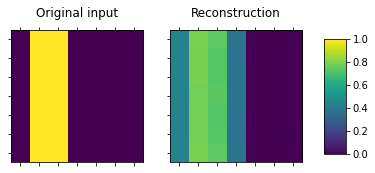

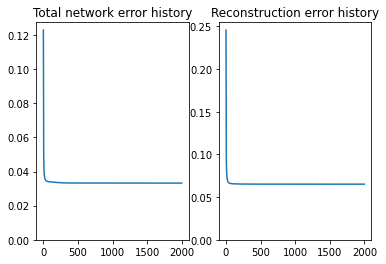

[0.00356909 0.00278576 0.00164956 0.01962937 0.00321631 0.00152083
 0.00576962 0.00184203 0.22519525 0.0048345 ]


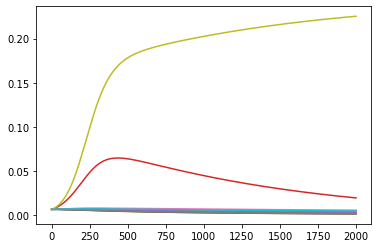

In [3]:
#net.plot_weights()
data = flat_data[2,1]
rep_list = net.test_frame(data, 2000)
print(rep_list[-1])
#net.forward_pass(data)
#rep_list.append(net.layers[-1].y_activity)
reps = np.vstack(rep_list)
for i in range(np.shape(reps)[1]):
    plt.plot(reps[:,i])

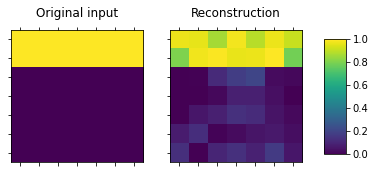

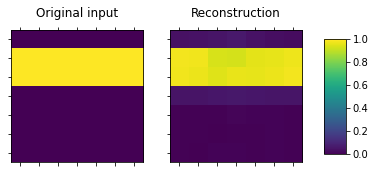

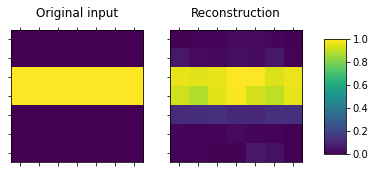

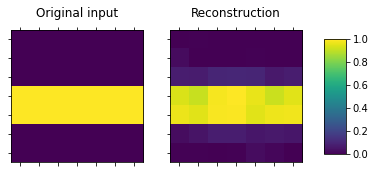

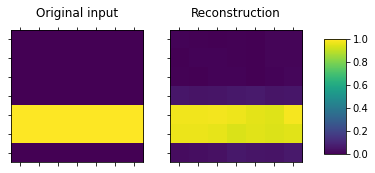

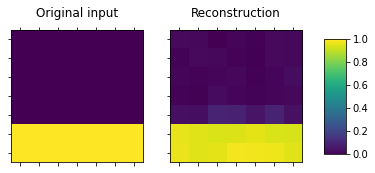

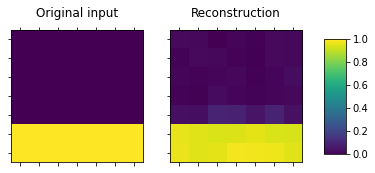

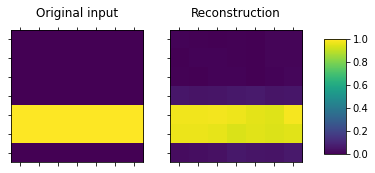

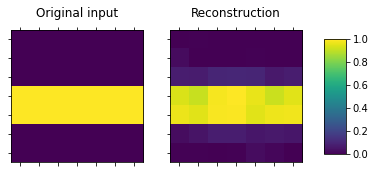

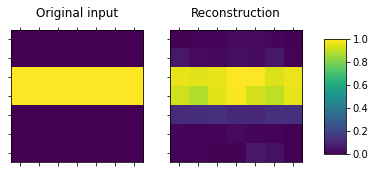

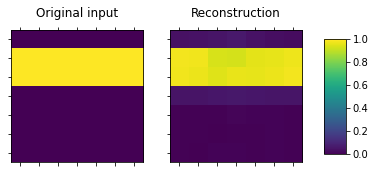

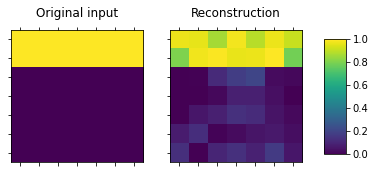

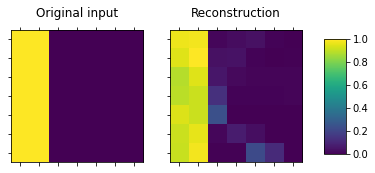

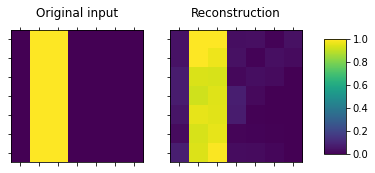

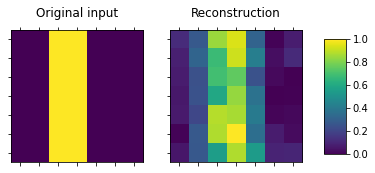

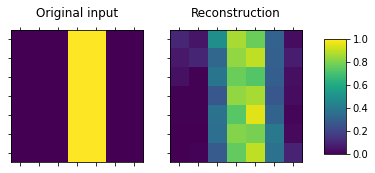

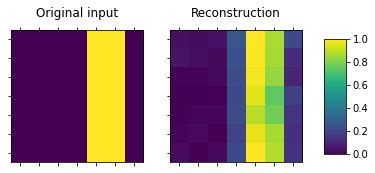

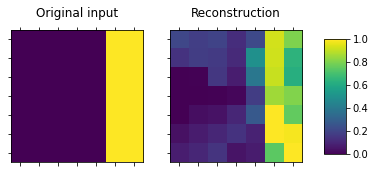

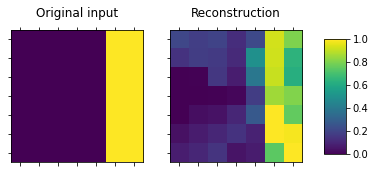

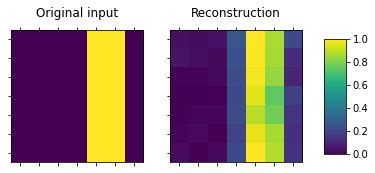

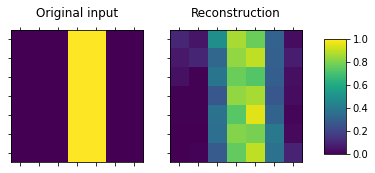

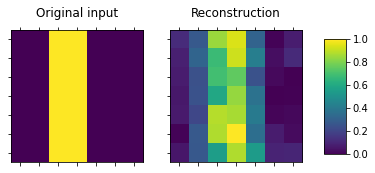

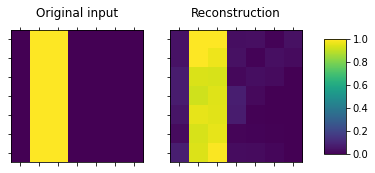

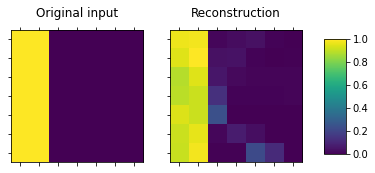

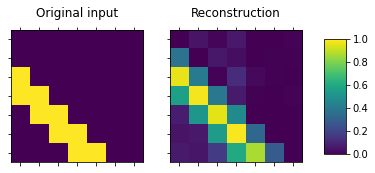

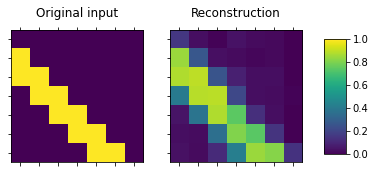

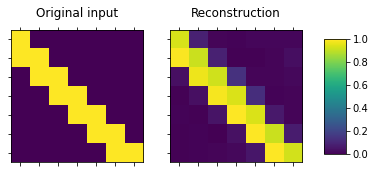

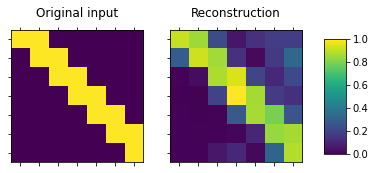

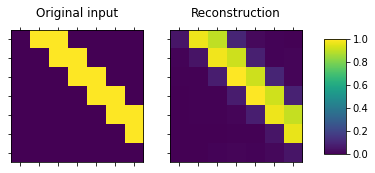

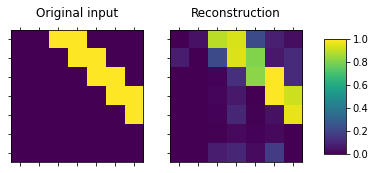

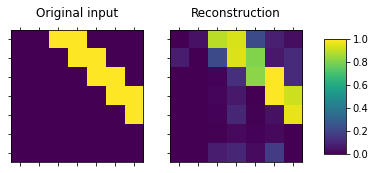

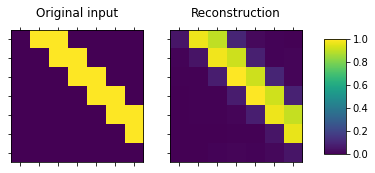

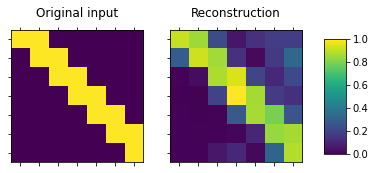

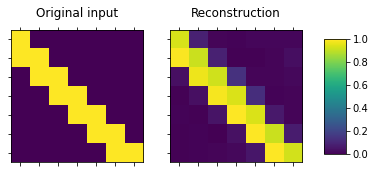

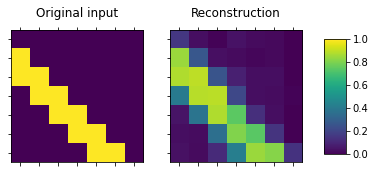

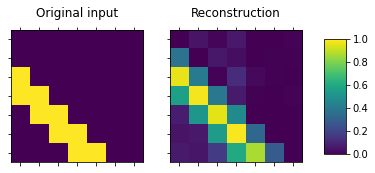

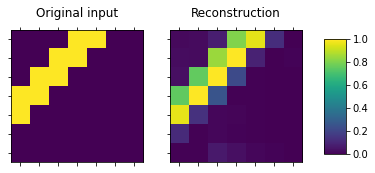

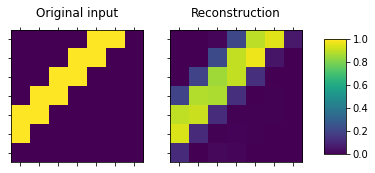

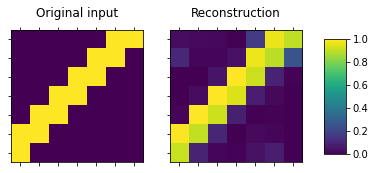

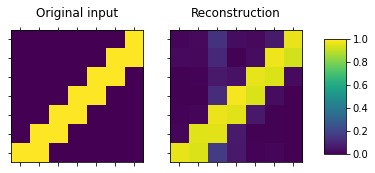

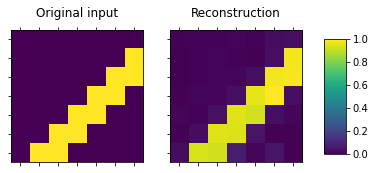

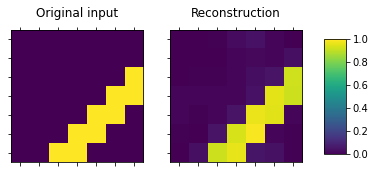

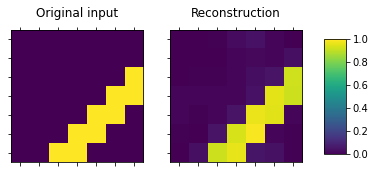

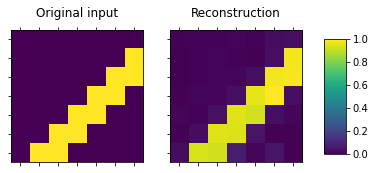

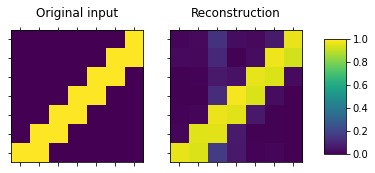

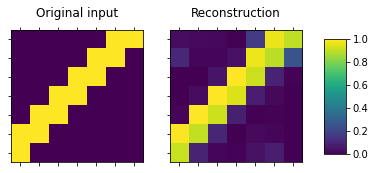

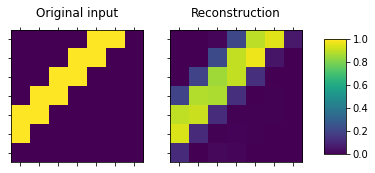

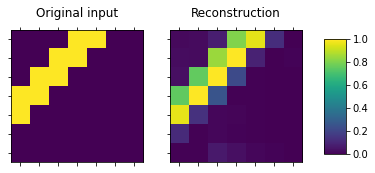

In [ ]:
net.reset_act()
steps = 500
a=net.test_sequence(flat_data[0],steps, True)
a=net.test_sequence(flat_data[1],steps, True)
a=net.test_sequence(flat_data[2],steps, True)
a=net.test_sequence(flat_data[3],steps, True)
a=net.test_sequence(flat_data[4],steps, True)
a=net.test_sequence(flat_data[5],steps, True)
a=net.test_sequence(flat_data[6],steps, True)
a=net.test_sequence(flat_data[7],steps, True)

In [ ]:
net.test_frame(flat_data[0,4], 5000)
#print(net.layers[2].td_prediction)
net.reconstruct_from(flat_data[0,0], 2,5000, False)
#net.reconstruct(flat_data[0,0],5000, False)
#print(net.layers[2].td_prediction)
net.test_frame(flat_data[0,4], 5000)
net.reconstruct_from(flat_data[0,0], 1,5000, False)

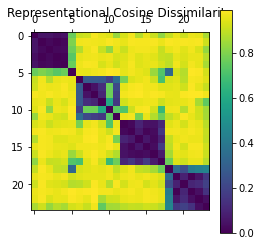

In [ ]:
rdm = net.rdm_sequences(flat_data, layer_no = 2, inference_steps = 2000, coc = "act")

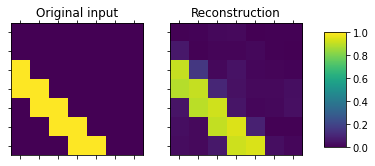

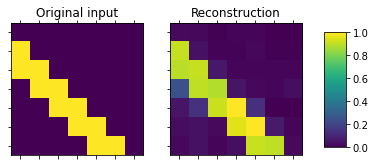

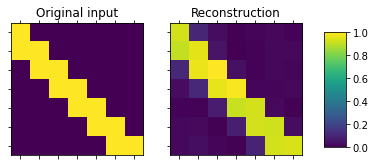

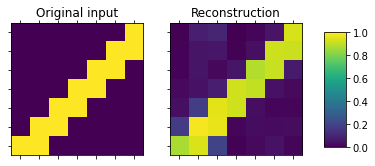

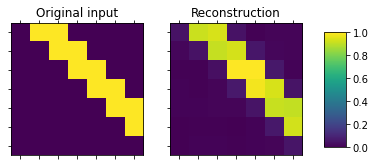

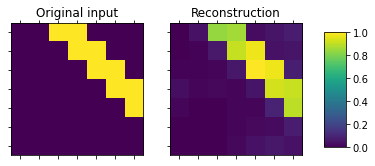

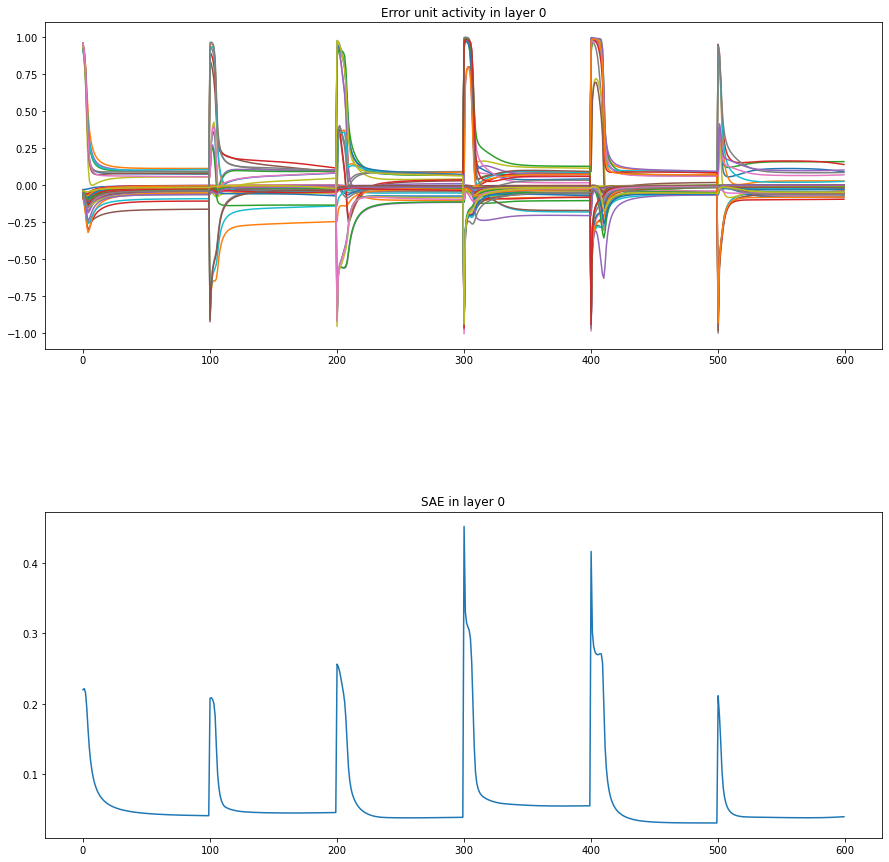

In [ ]:
violation_data_2 = flat_data[4].copy()
violation_data_2[-3] = flat_data[7,2].copy()
#violation_data_2[-3] = np.random.rand(dataWidth*dataWidth)
net.reset_act()
#net.inference_pass(flat_data[4,0], 1000)
net.test_sequence_record_error(violation_data_2, 100, True, record_layer = 0)